In [1]:
import librosa
import IPython
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
import ot
from scipy.sparse import csr_matrix

from utils import *

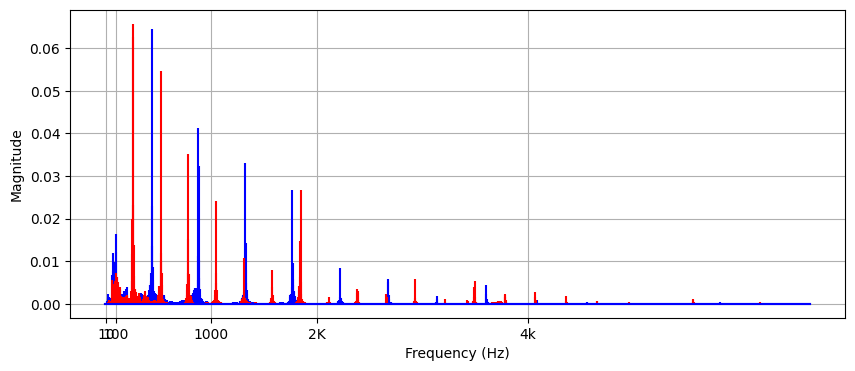

In [90]:
# Create 440Hz (A4) and 1046.5 (C5) sine waves

sr = 44100
duration = 0.3
frames = np.arange(duration * sr) / sr

smooth_len = 1000
smoothing = np.linspace(0, 1, smooth_len)

A_signal, sr = librosa.load('A.wav', sr=44100, duration=duration)
A_signal[:smooth_len] *= smoothing
A_signal[-smooth_len:] *= np.flip(smoothing)
C_signal, _ = librosa.load('C.wav', sr=44100, duration=duration)
C_signal[:smooth_len] *= smoothing
C_signal[-smooth_len:] *= np.flip(smoothing)

A_fft = np.fft.fft(A_signal)
C_fft = np.fft.fft(C_signal)
n = len(A_signal)
frequency = np.fft.fftfreq(n, d=1/sr)
frequency = frequency[:len(frequency) // 2]

# Take the magnitude of the FFT and normalize it
A_magnitude = np.abs(A_fft)[:len(frequency)]
A_magnitude /= np.sum(A_magnitude)
C_magnitude = np.abs(C_fft)[:len(frequency)]
C_magnitude /= np.sum(C_magnitude)


index = 2000

# Plot the frequency spectrum
plt.figure(figsize=[10, 4])
plt.stem(frequency[:index], A_magnitude[:index], 'b', markerfmt=" ", basefmt="-b")
plt.stem(frequency[:index], C_magnitude[:index], 'r', markerfmt=" ", basefmt="-b")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
# plt.xscale('log')
plt.xticks([10, 100, 1000, 2000, 4000], ['10', '100', '1000', '2K', '4k'])
plt.grid(True)
plt.show()

In [89]:
frequency.shape

(6615,)

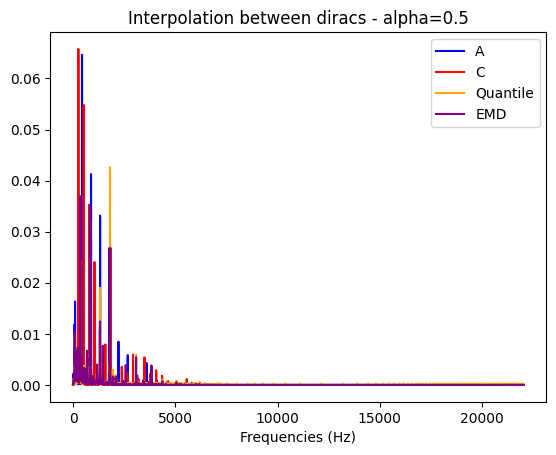

In [96]:
# Optimal transport

alpha = 0.5

# Quantile method 

quantile_interpolation = quantile_optimal_transport(A_magnitude, C_magnitude, alpha=alpha)
quantile_interpolation /= np.sum(quantile_interpolation)

# EMD 

emd_plan = ot.emd_1d(frequency, frequency, A_magnitude, C_magnitude)

emd_plan = csr_matrix(emd_plan)
emd_interpolation = np.zeros(len(frequency))
row, col = emd_plan.nonzero()
for i, j in zip(row, col):
    index = get_frequency(i, j, alpha=alpha, method='int')
    emd_interpolation[index] += emd_plan[i, j]
emd_interpolation /= np.sum(emd_interpolation)

plt.plot(frequency, A_magnitude, label=f"A", color="blue")
plt.plot(frequency, C_magnitude, label=f"C", color="red")
plt.plot(frequency, quantile_interpolation, label='Quantile', color="orange")
plt.plot(frequency, emd_interpolation, label='EMD', color="purple")
plt.xlabel("Frequencies (Hz)")
plt.title(f"Interpolation between diracs - alpha={alpha}")
plt.legend()
plt.show()


In [97]:
a = np.fft.ifft(emd_interpolation)
audio_widgets = []

title = widgets.Label(f'Quantile interpolation - alpha={0.5}')

audio_player = IPython.display.Audio(data=a, rate=sr)
out = widgets.Output()
with out:
    display(audio_player)
combined_widget = widgets.VBox([title, out])
audio_widgets.append(combined_widget)

grid = widgets.VBox(audio_widgets)
grid

/Users/davidvaldivia/IASD/memoire/audio_ot/.venv/lib/python3.9/site-packages/IPython/lib/display.py:172: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)
